In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
import statsmodels.api as sm
import xgboost as xgb
import seaborn as sns
import pickle
import joblib

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform, zscore
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve, ConfusionMatrixDisplay, auc
from sklearn.ensemble import BaggingClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical

# Cargar datos y primera revisión

In [102]:
# Leer desde URL
df = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/logistic-regression-project-tutorial/main/bank-marketing-campaign-data.csv', sep=';')
df.head() # Revisión de las primeras filas del dataframe

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [103]:
# Dimensiones del dataframe
df.shape 
# Información sobre el contenido de cada columna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [104]:
# Ver información estadística descriptiva base
df.describe(include='all')

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188,41188,41188,41188,41188,41188,41188,41188,41188,...,41188.000000,41188.000000,41188.000000,41188,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188
unique,NaN,12,4,8,3,3,3,2,10,5,...,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,2
top,NaN,admin.,married,university.degree,no,yes,no,cellular,may,thu,...,NaN,NaN,NaN,nonexistent,NaN,NaN,NaN,NaN,NaN,no
freq,NaN,10422,24928,12168,32588,21576,33950,26144,13769,8623,...,NaN,NaN,NaN,35563,NaN,NaN,NaN,NaN,NaN,36548
mean,40.02406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.567593,962.475454,0.172963,NaN,0.081886,93.575664,-40.502600,3.621291,5167.035911,NaN
std,10.42125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.770014,186.910907,0.494901,NaN,1.570960,0.578840,4.628198,1.734447,72.251528,NaN
min,17.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.000000,0.000000,NaN,-3.400000,92.201000,-50.800000,0.634000,4963.600000,NaN
25%,32.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,999.000000,0.000000,NaN,-1.800000,93.075000,-42.700000,1.344000,5099.100000,NaN
50%,38.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,999.000000,0.000000,NaN,1.100000,93.749000,-41.800000,4.857000,5191.000000,NaN
75%,47.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.000000,999.000000,0.000000,NaN,1.400000,93.994000,-36.400000,4.961000,5228.100000,NaN


In [105]:
# Identificar valores nulos en valor porcentual 
df.isnull().mean()*100

age               0.0
job               0.0
marital           0.0
education         0.0
default           0.0
housing           0.0
loan              0.0
contact           0.0
month             0.0
day_of_week       0.0
duration          0.0
campaign          0.0
pdays             0.0
previous          0.0
poutcome          0.0
emp.var.rate      0.0
cons.price.idx    0.0
cons.conf.idx     0.0
euribor3m         0.0
nr.employed       0.0
y                 0.0
dtype: float64

In [106]:
# Identificamos los valores únicos de cada columna del dataframe
n_unicos = df.nunique()
n_unicos

age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64

El resultado no muestra columnas con valores constantes (==1). Por lo tanto, por el momento no eliminamos columnas del dataframe original

In [107]:
# Identificar si existen filas duplicadas
duplicidades = df.duplicated().sum()
print (f'Las filas duplicadas encontradas ascienden a {duplicidades}')

Las filas duplicadas encontradas ascienden a 12


In [108]:
# Revisamos las filas duplicadas
df[df.duplicated()]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
20216,55,services,married,high.school,unknown,no,no,cellular,aug,mon,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
20534,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no
25217,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
28477,24,services,single,high.school,no,yes,no,cellular,apr,tue,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no
32516,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no


In [109]:
df = df.drop_duplicates()

# Distribución y relación entre variables

In [110]:
# Identificar tipos de variables
var_num = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
var_cat = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Variables numéricas:", var_num)
print("Variables categóricas:", var_cat)

Variables numéricas: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Variables categóricas: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


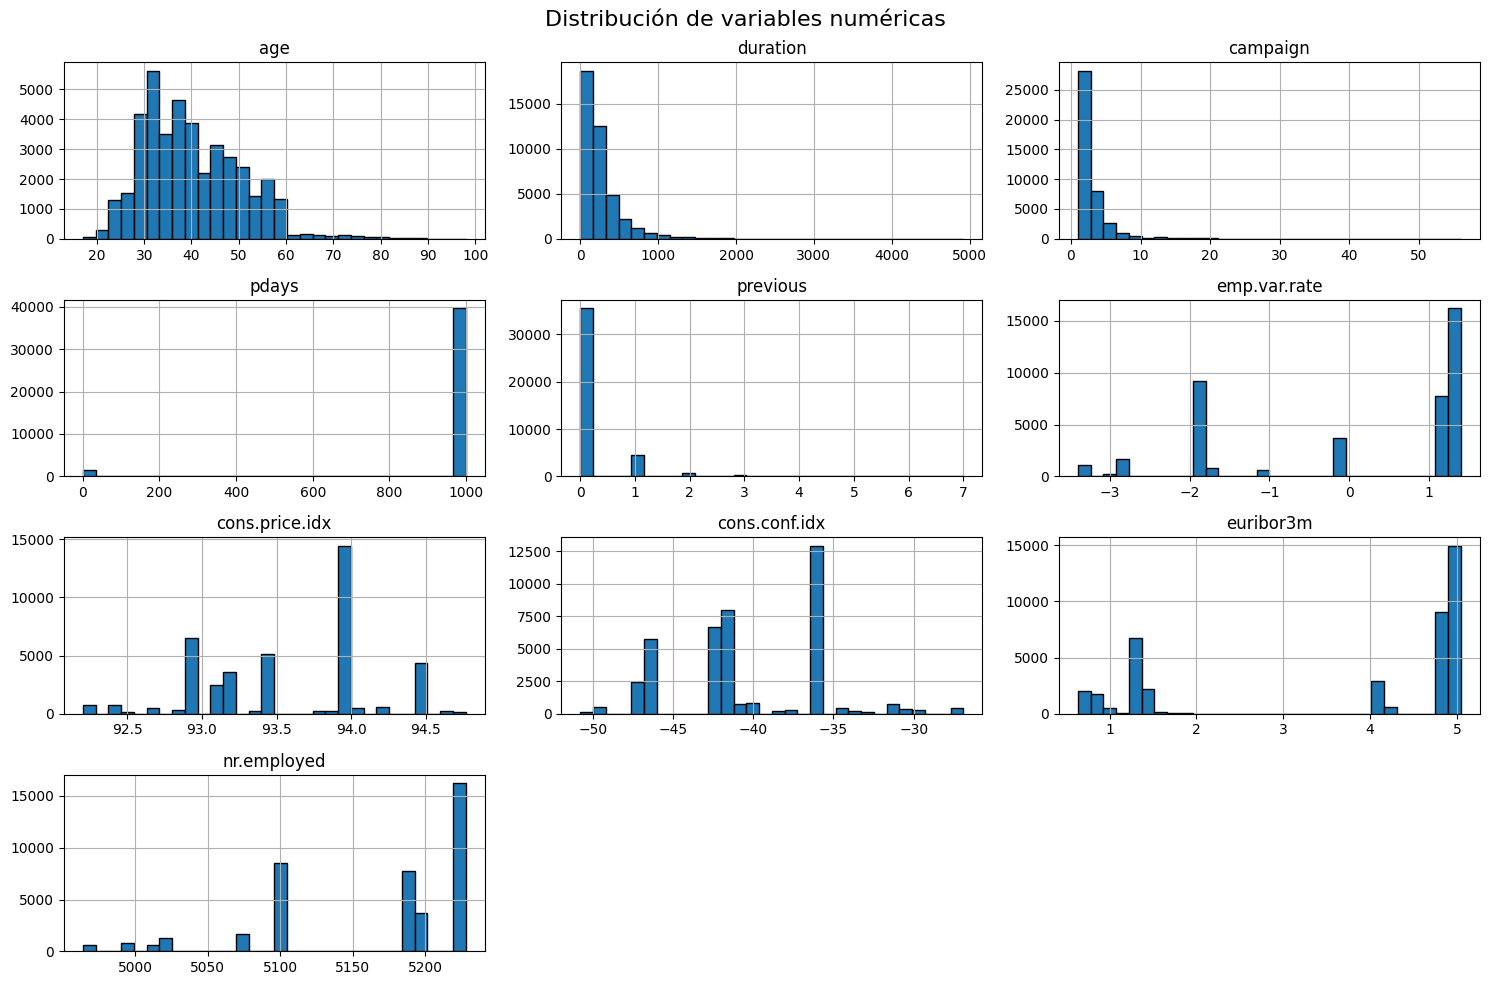

In [111]:
# Vusualización de la distribución de variables numéricas
df[var_num].hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.suptitle("Distribución de variables numéricas", fontsize=16)
plt.tight_layout()
plt.show()

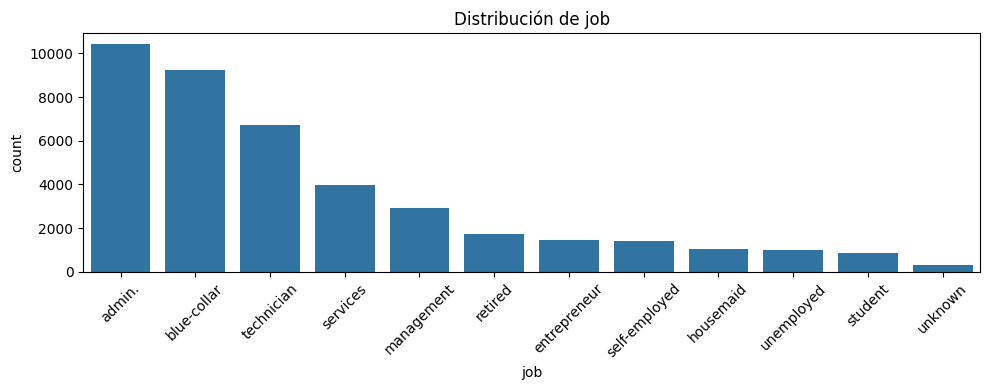

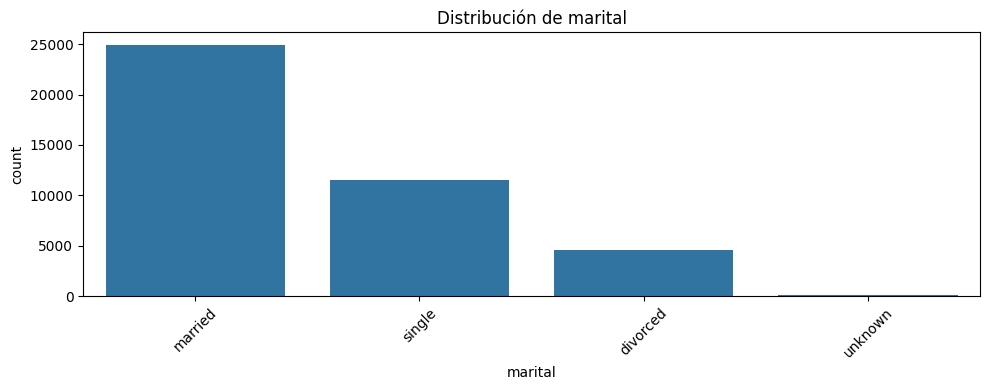

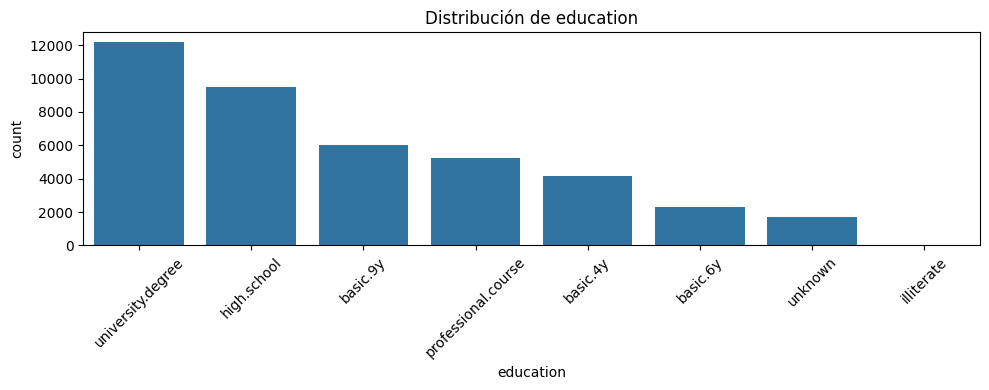

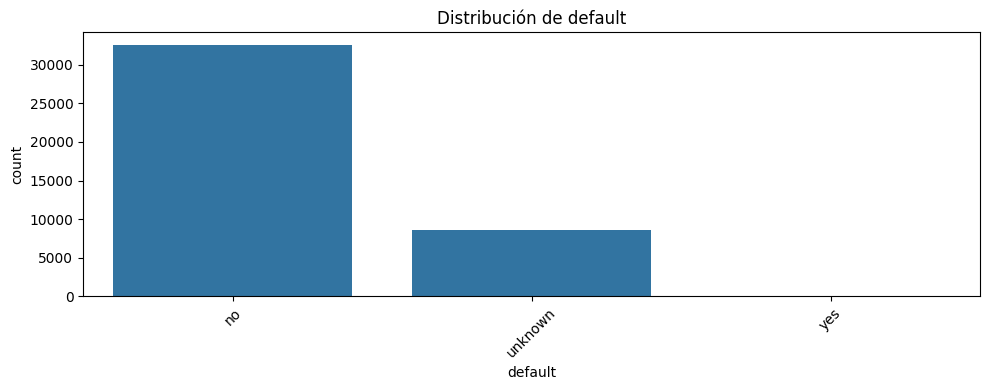

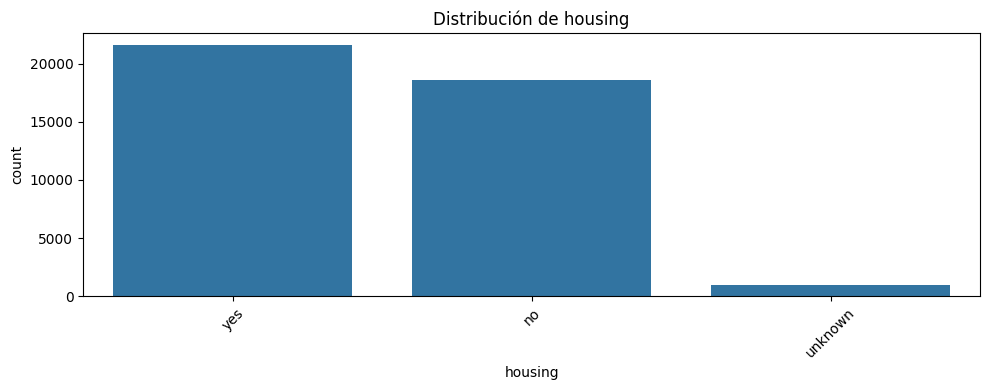

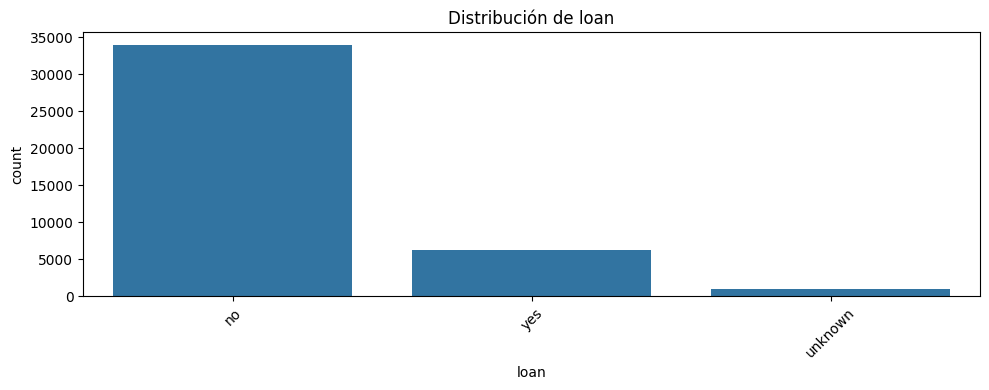

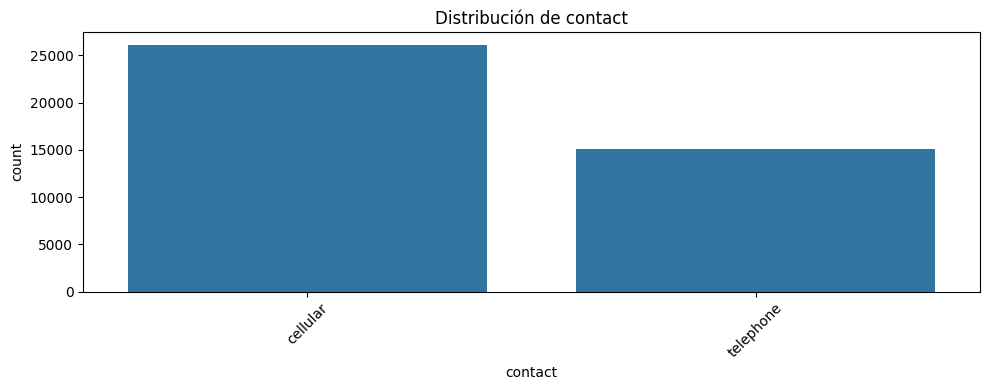

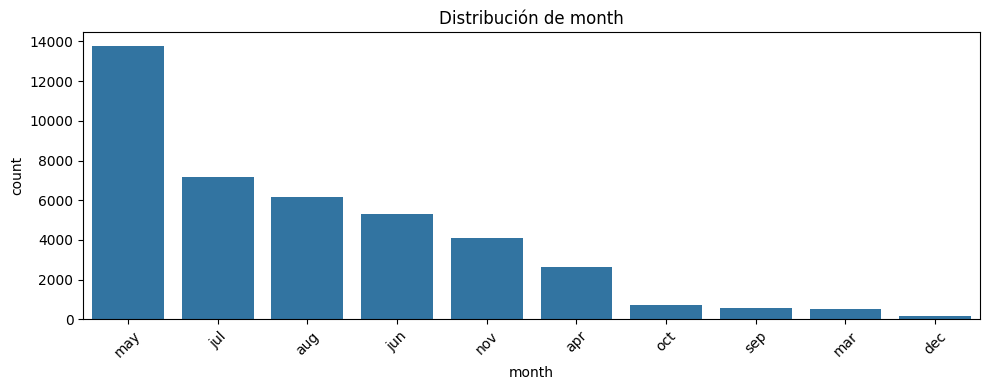

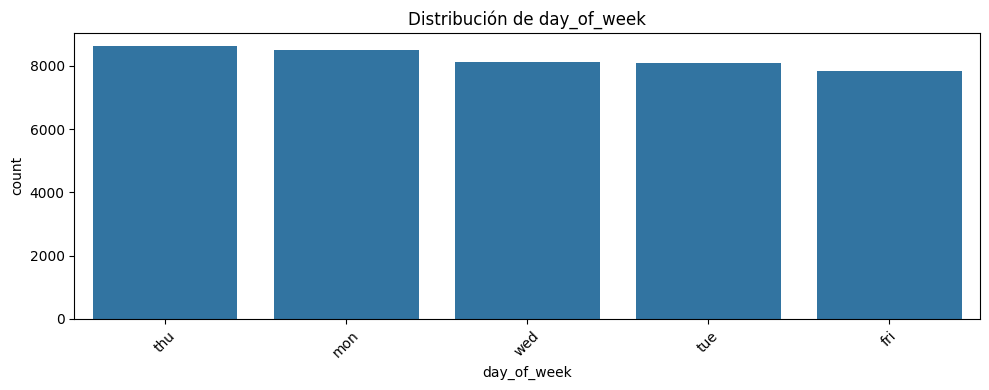

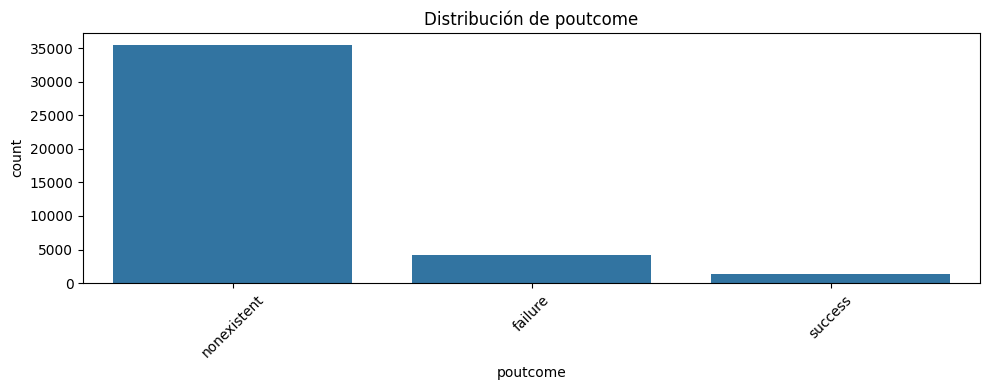

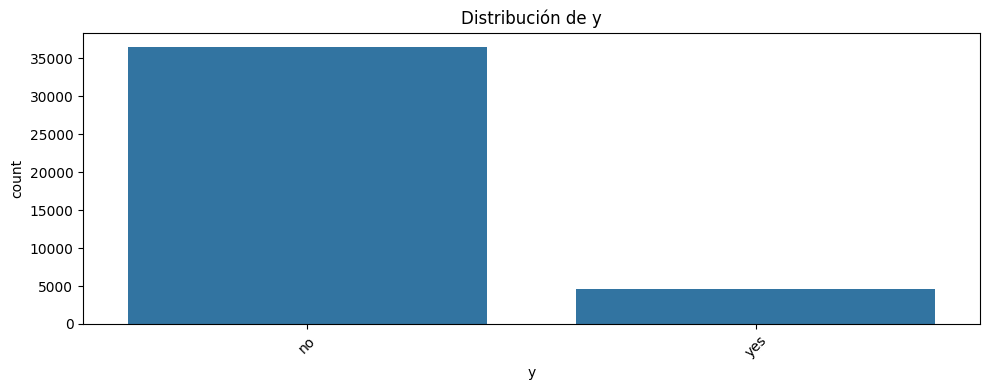

In [112]:
# Visualización de variables categóricas
for col in var_cat:
    if df[col].nunique() < 30:
        plt.figure(figsize=(10, 4))
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        plt.title(f"Distribución de {col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [113]:
# Codificación de variables categóricas
df['y_codificada'] = df['y'].map({'no': 0, 'yes': 1})

In [114]:
# Separamos las predictoras de la etiqueta
X = df.drop(columns=['y', 'y_codificada'])
y = df['y_codificada']

In [115]:
# Creación del preprocesador (ColumnTransformer)
preprocesador = ColumnTransformer(transformers=[
    ('num', StandardScaler(), var_num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), var_cat) # Se aplica a var_cat para convertirlas en variables binarias (codificación one-hot)
])

In [116]:
# Construcción del pipeline completo
pipeline = Pipeline(steps=[
    ('preprocesado', preprocesador),
    ('modelo', LogisticRegression(max_iter=1000)) # Entrena un modelo de Regresión Logística con hasta 1000 iteraciones
])

In [117]:
# Analizar la representatividad de cada clase en y
print(y.value_counts()) 

y_codificada
0    36537
1     4639
Name: count, dtype: int64


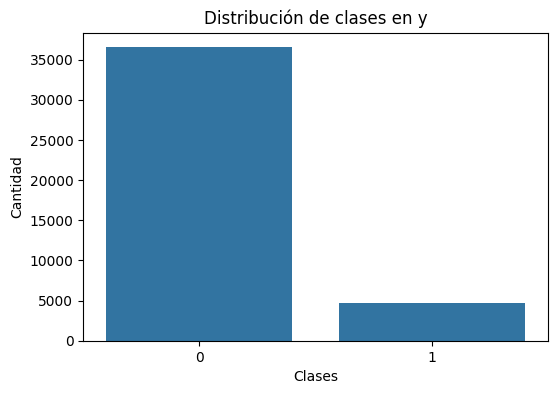

In [118]:
# Visualización en gráfico de barras
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Distribución de clases en y")
plt.ylabel("Cantidad")
plt.xlabel("Clases")
plt.show()

Como se puede observar, nuestros datos cuentan con una mayor representatividad de la clase 0. Para paliar este defecto en los datos que usaremos para entrenar a nuestro modelo, usamos una división estratificada de los datos que respete las proporciones de cada clase dentro de y.

# Partición del dataset en conjunto de entrenamiento y test

In [119]:
# División estratificada para respetar proporción de 0s y 1s
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,          # 20% para test
    stratify=y,              # Mantiene proporción de clases
    random_state=42          # Reproducibilidad
)

print(f"Tamaño conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño conjunto de test: {X_test.shape}")

Tamaño conjunto de entrenamiento: (32940, 20)
Tamaño conjunto de test: (8236, 20)


# Observaciones influyentes

In [120]:
# Cálculo de Cook's distance
# Confirmar que X_stats y y_train son sólo numéricos
X_stats = X_train.select_dtypes(include=['number']).copy()  # solo columnas numéricas
X_stats = sm.add_constant(X_stats)  # agregar constante

y_stats = pd.to_numeric(y_train, errors='coerce')  

# Paso 2: Ajuste del modelo
modelo = sm.OLS(y_stats, X_stats).fit()

# Paso 3: Cálculo de influencia y Cook's Distance
influencia = modelo.get_influence()
cooks_d = influencia.cooks_distance[0]

# Mostrar observaciones con posible influencia alta
umbral = 4 / len(X_stats)
puntos_influyentes = np.where(cooks_d > umbral)[0]

print(f"Observaciones con Cook's Distance > {umbral:.4f}:")
print(puntos_influyentes)

Observaciones con Cook's Distance > 0.0001:
[    1     9    16 ... 32928 32930 32936]


Cook's distance mide cuánto cambia el modelo al eliminar una observación. Un mayor valor indica que esa observación tiene un impacto considerable en los coeficientes del modelo. En este caso, el umbral de 0.0001 ha identificado un conjunto considerable de puntos.
Procedemos a la visualización para detectar patrones.

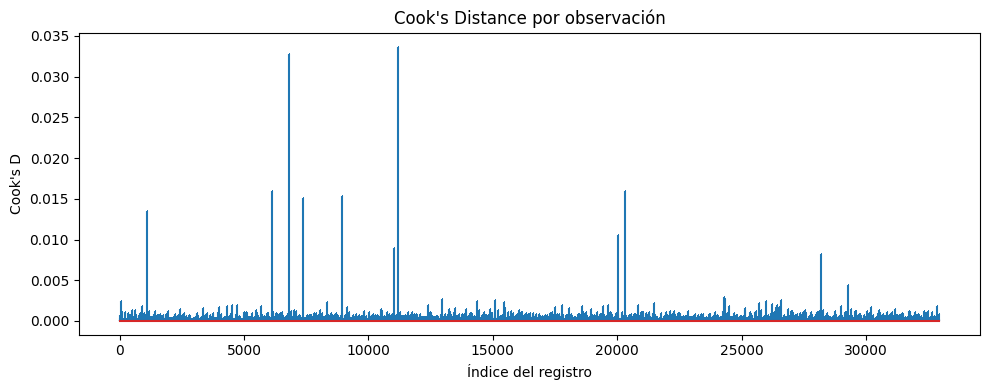

Observaciones influyentes detectadas: 4379


In [121]:
# Visualizamos valores de Cook's Distance
plt.figure(figsize=(10, 4))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.title("Cook's Distance por observación")
plt.xlabel("Índice del registro")
plt.ylabel("Cook's D")
plt.tight_layout()
plt.show()

# Umbral de influencia (común: 4/n)
umbral = 4 / len(X_train)
influentes = np.where(cooks_d > umbral)[0]
print(f"Observaciones influyentes detectadas: {len(influentes)}")

# Eliminamos del set de entrenamiento
X_train_filtrado = X_train.drop(X_train.index[influentes]).reset_index(drop=True)
y_train_filtrado = y_train.drop(y_train.index[influentes]).reset_index(drop=True)

In [122]:
# Filtrar conjunto de test con coherencia respecto al de entrenamiento
z_scores = np.abs(zscore(X_test['duration']))
X_test_filtrado = X_test[z_scores < 3]
y_test_filtrado = y_test[X_test_filtrado.index]

# Extracción de características

In [123]:
# Agrupación de edad por tramos
df['age_group'] = pd.cut(df['age'], bins=[17, 30, 45, 60, 100],
labels=['Joven', 'Adulto', 'Maduro', 'Senior'])

In [124]:
# Codificar variables categóricas recién creadas
# Añadimos la nueva columna:
df['age_group'] = df['age_group'].astype(str)  # Asegura que no sea categoría con nulos

#La incluimos en la lista de variables categóricas:
var_cat.append('age_group')

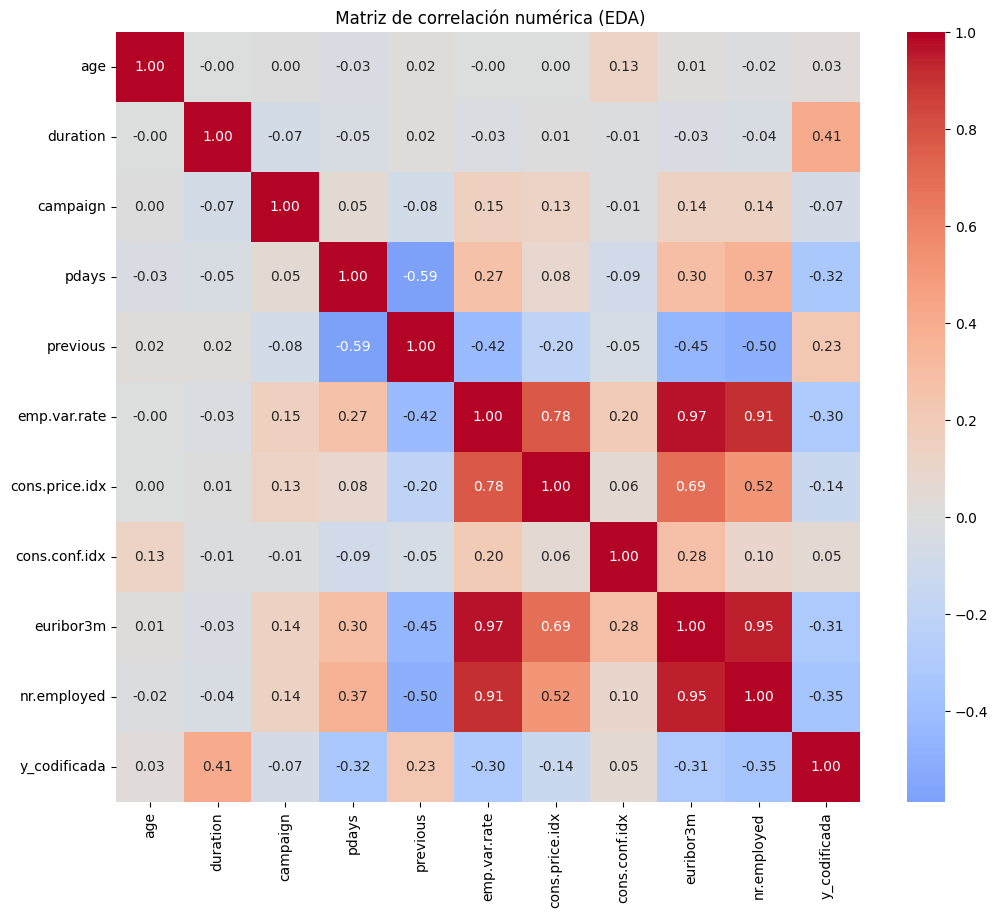

,Variable,VIF
0,const,526802.928495
9,euribor3m,64.436760
6,emp.var.rate,33.197935
10,nr.employed,31.607413
7,cons.price.idx,6.343373
8,cons.conf.idx,2.642949
5,previous,1.795662
4,pdays,1.619062
3,campaign,1.038076
1,age,1.019561


In [125]:
#5.3.1 – Matriz de correlación
plt.figure(figsize=(12, 10))
corr = df.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title(' Matriz de correlación numérica (EDA)')
plt.show()

#5.3.2 – Cálculo de VIF (Variance Inflation Factor) para detectar multicolinealidad

# 1. Codificar variables categóricas
X_vif = pd.get_dummies(X_train, drop_first=True)

# 2. Garantizar solo columnas numéricas y sin NaN
X_vif = X_vif.select_dtypes(include=[np.number]).copy()
X_vif = X_vif.dropna()

# 3. Añadir constante
X_vif = sm.add_constant(X_vif)

# 4. Calcular VIF
vif_df = pd.DataFrame()
vif_df["Variable"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# 5. Mostrar ordenado
vif_df.sort_values("VIF", ascending=False)

In [126]:
#5.3.3 – Reducción de multicolinealidad eliminando variables redundantes (VIF > 10)

# Variables con VIF alto y alta correlación entre si
variables_colineales = ['euribor3m', 'emp.var.rate', 'nr.employed']

# Decisión: nos quedamos solo con 'euribor3m' como representativa
variables_a_eliminar = ['emp.var.rate', 'nr.employed']

# Eliminamos del conjunto de entrenamiento y prueba si ya están separados
X_train_reducido = X_train.drop(columns=variables_a_eliminar, errors='ignore')
X_test_reducido = X_test.drop(columns=variables_a_eliminar, errors='ignore')

print(f"Variables eliminadas por alta colinealidad: {variables_a_eliminar}")

Variables eliminadas por alta colinealidad: ['emp.var.rate', 'nr.employed']


# Selección de características

In [127]:
# Evaluación de importancia de características con XGBoost
# Usamos los datos ya transformados
X_encoded = pd.get_dummies(X, drop_first=True)

model_xgb = xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
model_xgb.fit(X_encoded, y)

# Definimos importancias
importancias = model_xgb.feature_importances_
features = X_encoded.columns

importancia_df = pd.DataFrame({'Variable': features, 'Importancia': importancias})
importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)

# Filtrar variables con más de 1% de importancia
umbral = 0.01
vars_seleccionadas = importancia_df[importancia_df['Importancia'] > umbral]['Variable'].tolist()

print(f"Variables seleccionadas (>1%): {len(vars_seleccionadas)}")
display(importancia_df.head(15))

Variables seleccionadas (>1%): 14


,Variable,Importancia
9,nr.employed,0.447728
1,duration,0.052772
45,month_oct,0.047571
5,emp.var.rate,0.038510
52,poutcome_success,0.036056
7,cons.conf.idx,0.030871
43,month_may,0.023199
3,pdays,0.022979
6,cons.price.idx,0.014644
8,euribor3m,0.013710


In [128]:
# Filtrado del conjunto de datos con las variables más importantes
X_filtrado = X_encoded[vars_seleccionadas]

# Escalado de las características

In [129]:
preprocesador = ColumnTransformer(transformers=[
    ('num', StandardScaler(), var_num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), var_cat)
])

# Construcción del pipeline y primer entrenamiento

In [130]:
# 1. Codificación variable objetivo
df['y_codificada'] = df['y'].map({'no': 0, 'yes': 1})

# 2. Separación de variables
X = df.drop(columns=['y', 'y_codificada'])
y = df['y_codificada']

# 3. Detección de tipos
variables_num = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
variables_cat = X.select_dtypes(include=['object', 'category']).columns.tolist()

# 4. Preprocesador
preprocesador = ColumnTransformer(transformers=[
    ('num', StandardScaler(), variables_num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), variables_cat)
])

# 5. División en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6. Pipeline con regresión logística
pipeline = Pipeline(steps=[
    ('preprocesado', preprocesador),
    ('modelo', LogisticRegression(max_iter=1000))
])

# 7. Entrenamiento inicial (sin evaluación)
pipeline.fit(X_train, y_train)

# 8. Guardar el pipeline para producción
with open('modelo_logistico_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)
print("Pipeline guardado como 'modelo_logistico_pipeline.pkl'")

Pipeline guardado como 'modelo_logistico_pipeline.pkl'


# Optimización con búsqueda de hiperparámetros

In [131]:
# Espacio de búsqueda aleatoria
param_dist = {
    'modelo__C': loguniform(0.001, 100),
    'modelo__solver': ['liblinear', 'lbfgs']
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)
print("Mejores parámetros:", random_search.best_params_)

# Segunda búsqueda con GridSearchCV
param_grid = {
    'modelo__C': [0.1, 1, 10],
    'modelo__solver': ['liblinear']
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train, y_train)

# Guardar el mejor modelo
modelo_final = grid_search.best_estimator_
print(f"Mejor combinación de parámetros: {grid_search.best_params_}")
print(f"Accuracy validación cruzada: {grid_search.best_score_:.2%}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Mejores parámetros: {'modelo__C': np.float64(0.9846738873614566), 'modelo__solver': 'liblinear'}
Mejor combinación de parámetros: {'modelo__C': 10, 'modelo__solver': 'liblinear'}
Accuracy validación cruzada: 91.15%


# Evaluación completa del modelo optimizado

Precisión en TRAIN: 91.21%
Precisión en TEST : 91.00%
Modelo generaliza bien.

Matriz de confusión:
[[7096  212]
 [ 529  399]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7308
           1       0.65      0.43      0.52       928

    accuracy                           0.91      8236
   macro avg       0.79      0.70      0.73      8236
weighted avg       0.90      0.91      0.90      8236



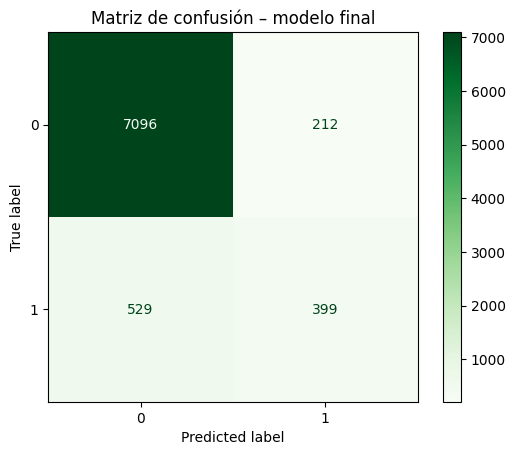

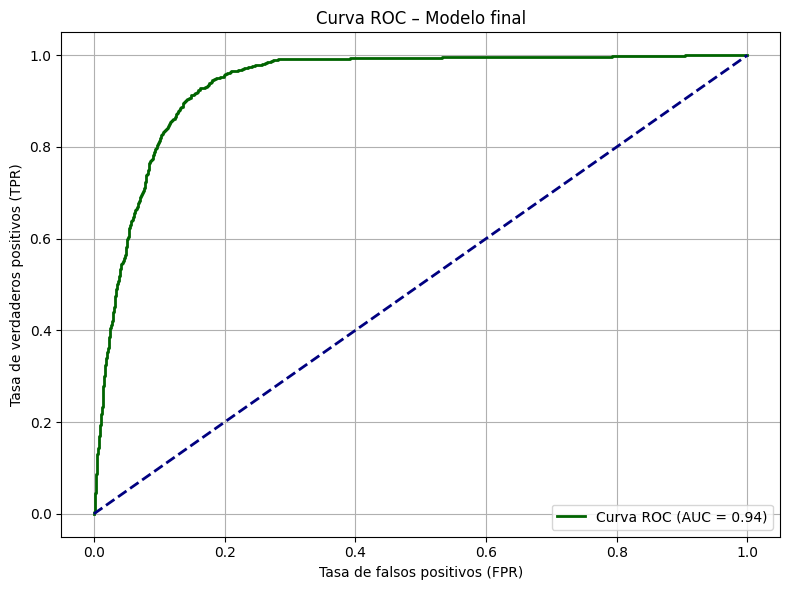

In [151]:
# Predicciones en test
y_test_pred = modelo_final.predict(X_test)

# Comparativa train vs test
y_train_pred = modelo_final.predict(X_train)
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print(f"Precisión en TRAIN: {acc_train:.2%}")
print(f"Precisión en TEST : {acc_test:.2%}")

# Detectar posible overfitting
if abs(acc_train - acc_test) > 0.05:
    print("Posible overfitting detectado.")
else:
    print("Modelo generaliza bien.")

# Matriz de confusión y reporte de clasificación
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_test_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_test_pred))

# Visualización de la matriz de confusión
ConfusionMatrixDisplay.from_estimator(modelo_final, X_test, y_test, cmap='Greens')
plt.title("Matriz de confusión – modelo final")
plt.show()

# Curva ROC y AUC
y_scores = modelo_final.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title("Curva ROC – Modelo final")
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

Evaluación Inicial del Modelo

1 - Rendimiento del modelo:

Precisión en entrenamiento: 91.21%
Precisión en test: 91.00% 

Conclusión: La diferencia es mínima (0.21%), lo que indica que el modelo generaliza bien y no presenta signos de overfitting.

2 – La matriz de confusión muestra la distribución de aciertos y errores:

- 7096 (Real Negativo-TN) => Casos donde la clase real era 0 (negativo) y el modelo predijo 0 correctamente
- 212 (Falsos Positivos-FP) => Casos donde la clase real era 0, pero el modelo predijo erróneamente 1
- 529 (Real Positivo-FN) => Casos donde la clase real era 1, pero el modelo no los detectó y predijo 0
- 399 (Verdaderos Positivos-TP) => Casos donde la clase real era 1 y el modelo los clasificó correctamente

3 - Interpretación
- Evaluación de rendimiento El modelo tiene un rendimiento muy sólido y balanceado entre entrenamiento y test. Lo que sugiere generalización adecuadada. La diferencia en la precisión (del 0.21%) entre el conjunto de entrenamiento y el conjunto de prueba en pequeño. Ésto nos podría indicar que el modelo está aprendiendo patrones generales que funcionan con datos nuevos.
- Análisis de la matriz de confusión
El modelo es muy preciso en general, pero está teniendo dificultades para detectar positivos (recall bajo).

4 - Conclusiones 
Ajustaremos el modelo para alcanzar un mejor desempeño 

In [152]:
# Ajuste del modelo
pipeline = Pipeline(steps=[
    ('preprocesado', preprocesador),
    ('modelo', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Entrenar con el nuevo ajuste
pipeline.fit(X_train, y_train)

,steps,"[('preprocesado', ...), ('modelo', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



Matriz de Confusión después del ajuste:
[[6280 1028]
 [  89  839]]

Reporte de Clasificación actualizado:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      7308
           1       0.45      0.90      0.60       928

    accuracy                           0.86      8236
   macro avg       0.72      0.88      0.76      8236
weighted avg       0.93      0.86      0.88      8236



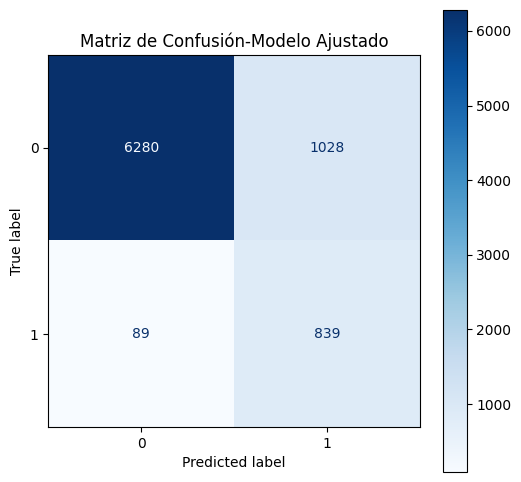

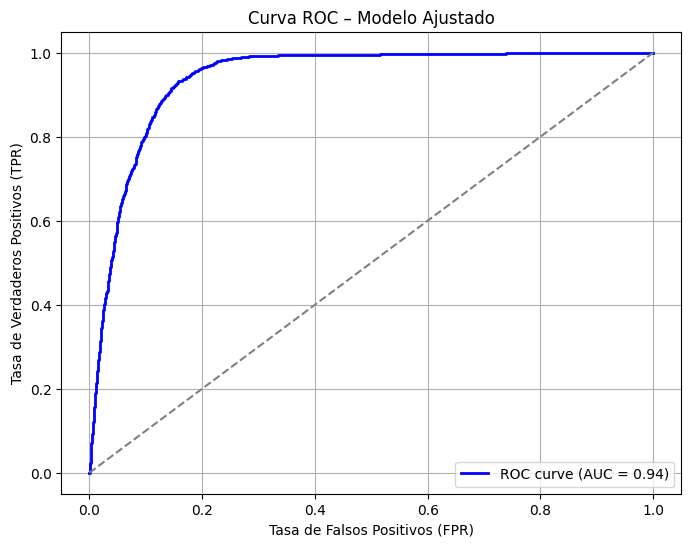

In [153]:
# Evaluación después del ajuste
# Predicción con el modelo ajustado
y_test_pred_ajustado = pipeline.predict(X_test)

# Matriz de confusión actualizada
print("\nMatriz de Confusión después del ajuste:")
print(confusion_matrix(y_test, y_test_pred_ajustado))

print("\nReporte de Clasificación actualizado:")
print(classification_report(y_test, y_test_pred_ajustado))

#Visualización de la Matriz de Confusión
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, cmap="Blues", ax=ax)
plt.title("Matriz de Confusión-Modelo Ajustado")
plt.show()

#Generación de la Curva ROC-AUC
y_probabilidades = pipeline.predict_proba(X_test)[:, 1]  # Probabilidades de la Clase 1
fpr, tpr, _ = roc_curve(y_test, y_probabilidades)  # Curva ROC
roc_auc = auc(fpr, tpr)  # Cálculo del área bajo la curva (AUC)

#Visualización de la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea base
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC – Modelo Ajustado")
plt.legend(loc="lower right")
plt.grid()
plt.show()

Evaluación del modelo tras el ajuste

1 – La matriz de confusión muestra la distribución de aciertos y errores:

- 6280 (Verdaderos Negativos-TN)
- 1028 (Falsos Positivos-FP)
- 29 (Falsos Negativos-FN)
- 839 (verdaderos positivo-TP)


3 - Interpretación
- Con el ajunte el modelo ha mejorado el recall de la clase positiva (llegando al 90%). Lo que reduce significativamente los falsos negativos aunque se ha sacrificado algo de precisión general y han aumentado los falsos positivos.

4- Conclusión
Tras el ajuste el modelo mejora la capacidad para predecir la detección de clientes potenciales.

# Exportación del modelo final

In [154]:
joblib.dump(pipeline, 'modelo_regresion_logistica_final.pkl')
print("Modelo exportado como 'modelo_regresion_logistica_final.pkl'")

Modelo exportado como 'modelo_regresion_logistica_final.pkl'


# Predicción en nuevos clientes

In [157]:
# Cargar el modelo entrenado
pipeline = joblib.load('modelo_regresion_logistica_final.pkl')

# Simulación de un nuevo cliente (con todas las columnas necesarias)
nuevo_cliente = pd.DataFrame({
    'age': [34],
    'job': ['technician'],
    'marital': ['married'],
    'education': ['tertiary'],
    'default': ['no'],
    'balance': [1500],
    'housing': ['yes'],
    'loan': ['no'],
    'contact': ['cellular'],
    'day': [15],
    'month': ['jun'],
    'duration': [320],
    'campaign': [2],
    'pdays': [-1],
    'previous': [0],
    'poutcome': ['unknown'],
    'cons.price.idx': [93.918],
    'cons.conf.idx': [-42.7],
    'euribor3m': [4.961],
    'nr.employed': [5228.1],
    'emp.var.rate': [-1.8],
    'day_of_week': ['wed'],
    'age_group': ['adult']  
})

# Predicción sobre nuevo cliente
prediccion = pipeline.predict(nuevo_cliente)
probabilidad = pipeline.predict_proba(nuevo_cliente)[:, 1]

In [158]:
# Mostrar ambos valores (predicción y probabilidad)
print(f"Predicción: {prediccion[0]}")
print(f"Probabilidad de clase positiva: {probabilidad[0]:.2%}")

Predicción: 1
Probabilidad de clase positiva: 99.81%


El modelo estima con altísima confianza que ese nuevo cliente contratará un depósito a largo plazo.

# Exportación de clientes recomendados

In [159]:
# Predicciones en todo el test
y_pred = modelo_final.predict(X_test)
y_proba = modelo_final.predict_proba(X_test)[:, 1]

# DataFrame con clientes recomendados
df_resultados = X_test.copy()
df_resultados['prediccion'] = y_pred
df_resultados['probabilidad_exito'] = y_proba

clientes_a_llamar = df_resultados[df_resultados['probabilidad_exito'] >= 0.50]

# Exportar lista de clientes recomendados
clientes_a_llamar.to_csv("clientes_recomendados.csv", index=False)
print("Archivo 'clientes_recomendados.csv' generado con éxito.")

Archivo 'clientes_recomendados.csv' generado con éxito.


In [160]:
# Cargar el CSV generado
clientes_exportados = pd.read_csv("clientes_recomendados.csv")

# Mostrar cantidad de filas y columnas
print(f"El CSV tiene {clientes_exportados.shape[0]} filas y {clientes_exportados.shape[1]} columnas.")

El CSV tiene 611 filas y 23 columnas.
